In [226]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import nltk
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import re
import string
import spacy
import pickle

In [227]:
df = pd.read_csv('JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [228]:
df[' Round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker'],
      dtype=object)

# Clean up data

In [229]:
df.columns = ['show_id', 'date', 'round', 'category', 'value', 'question', 'answer']

In [230]:
df['value'].replace({'None': '$0'}, inplace=True)

In [231]:
df['value'] = df['value'].apply(lambda x: int(x[1:].replace(',',''))) #remove $ remove comma and convert to int

In [232]:
df['year'] = df['date'].apply(lambda x: int(x[:4]))

In [233]:
df.head()

,show_id,date,round,category,value,question,answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


In [234]:
df['round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker'],
      dtype=object)

# Explore categories

In [235]:
df.category.value_counts()[:25]

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
ISLANDS                    301
WORLD CAPITALS             300
U.S. GEOGRAPHY             299
RELIGION                   297
SHAKESPEARE                294
OPERA                      294
LANGUAGES                  284
BALLET                     282
TELEVISION                 281
Name: category, dtype: int64

# Preprocess text (don't need to run this section)

In [22]:
# adapted from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Stemming
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    all_stopwords = nlp.Defaults.stop_words
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags and token not in all_stopwords])
    return texts_out

In [ ]:
def preprocessing(df):
    # takes df and completes all preprocessing steps (cleaning text, tokenization, lemmatization).
    # returns id2word and corpus
    d = pd.DataFrame(df.question.apply(lambda x: clean_text(x)))
    dw = list(sent_to_words(list(d.question)))
    lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
    id2word = gensim.corpora.Dictionary(lemm)
    corpus = [id2word.doc2bow(text) for text in lemm]
    return id2word, corpus

In [ ]:
df_question = pd.DataFrame(df.question.apply(lambda x: clean_text(x)))
data_words = list(sent_to_words(list(df_question.question)))
questions_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb

In [104]:
filename = './data_1a/questions_lemmatized'
outfile = open(filename,'wb')
pickle.dump(questions_lemmatized,outfile)
outfile.close()

In [27]:
id2word = gensim.corpora.Dictionary(questions_lemmatized)
corpus = [id2word.doc2bow(text) for text in questions_lemmatized]

In [106]:
filename = './data_1a/corpus'
outfile = open(filename,'wb')
pickle.dump(corpus,outfile)
outfile.close()

## Calculate coherence scores on 3 different years to find best number of topics

In [12]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
def compute_coherence_values(dictionary, corp, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
one_yr = df[df.year==1984]
d = pd.DataFrame(one_yr.question.apply(lambda x: clean_text(x)))
dw = list(sent_to_words(list(d.question)))
lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
id2word_1984 = gensim.corpora.Dictionary(lemm)
corpus_1984 = [id2word_1984.doc2bow(text) for text in lemm]
_, coherence_values_1984 = compute_coherence_values(dictionary=id2word_1984, corp=corpus_1984, texts=lemm, start=2, limit=100, step=6)

In [17]:
one_yr = df[df.year==1994]
d = pd.DataFrame(one_yr.question.apply(lambda x: clean_text(x)))
dw = list(sent_to_words(list(d.question)))
lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
id2word_1994 = gensim.corpora.Dictionary(lemm)
corpus_1994 = [id2word_1994.doc2bow(text) for text in lemm]
_, coherence_values_1994 = compute_coherence_values(dictionary=id2word_1994, corp=corpus_1994, texts=lemm, start=2, limit=100, step=6)

In [18]:
one_yr = df[df.year==2004]
d = pd.DataFrame(one_yr.question.apply(lambda x: clean_text(x)))
dw = list(sent_to_words(list(d.question)))
lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
id2word_2004 = gensim.corpora.Dictionary(lemm)
corpus_2004 = [id2word_2004.doc2bow(text) for text in lemm]
_, coherence_values_2004 = compute_coherence_values(dictionary=id2word_2004, corp=corpus_2004, texts=lemm, start=2, limit=100, step=6)

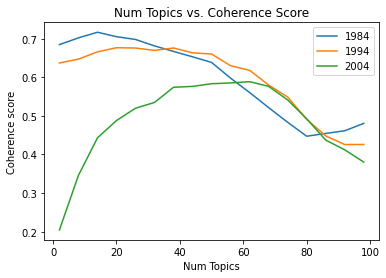

In [19]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_1984, label='1984')
plt.plot(x, coherence_values_1994, label='1994')
plt.plot(x, coherence_values_2004, label='2004')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics vs. Coherence Score')
plt.legend()
plt.show()

Based on coherence plots for 1984, 1994, and 2004, it looks like 15-20 topics is a reasonable amount for the full dataset. We don't want our topics to be too similar to each other

# Run LDA on full dataset

### Generate and save corpus and fitted model

In [28]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=20)

In [29]:
lda.save('./data_1a/lda_trained')

# Start Running Here!

### Load saved files

In [3]:
import pickle

In [4]:
filename = './data_1a/corpus'
infile = open(filename,'rb')
corpus = pickle.load(infile)
infile.close()

In [8]:
#! pip install python-Levenshtein

In [9]:
filename = './data_1a/lda_trained.id2word'
infile = open(filename,'rb')
id2word = pickle.load(infile)
infile.close()

In [13]:
filename = './data_1a/lda_trained'
lda = ldamodel.LdaModel.load(filename)

### Get LDA topics

In [15]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

get_lda_topics(lda, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,time,use,woman,include,film,s,country,term,know,part,see,city,will,state,island,become,play,hit,go,year
1,one,take,love,serve,title,get,company,mean,word,bird,type,name,find,president,line,capital,crew,tell,be,write
2,die,world,run,way,song,group,have,day,come,animal,work,war,star,author,movie,lead,win,set,put,begin
3,age,character,nickname,turn,feature,form,leave,can,may,name,bear,home,king,story,child,would,show,hear,actor,book
4,art,game,create,food,stand,novel,leader,people,name,open,name,century,give,head,introduce,refer,clue,music,nation,end
5,read,place,member,color,play,base,move,person,letter,share,found,river,help,foot,study,sound,team,record,ship,number
6,site,live,kill,cover,life,could,town,body,call,tree,hold,mile,want,rock,award,should,report,sell,sing,point
7,design,look,wear,order,school,publish,artist,dog,water,join,make,land,series,sign,ride,try,night,ask,say,change
8,visit,name,man,law,house,name,band,name,language,plant,wife,battle,build,sea,office,force,name,do,fire,flag
9,rule,brother,keep,symbol,role,element,meet,describe,follow,version,death,lose,son,family,earth,device,boy,honor,top,inspire


### Topics for document 0 

In [16]:
lda.get_document_topics(corpus[0])

[(4, 0.4975103), (6, 0.17497063), (19, 0.18584527)]

This shows that there is a 49 probability that this document is in topic 4, a 17% probability that it is in topic 6, etc.

### Get best topic for each doc

In [17]:
most_likely_topic=[]
for doc in corpus:
    likelihoods = dict(lda.get_document_topics(doc))
    most_likely_topic.append(max(likelihoods,key=likelihoods.get))

In [237]:
df['topic'] = most_likely_topic

In [238]:
df

,show_id,date,round,category,value,question,answer,year,topic
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004,4
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004,2
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004,17
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004,16
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004,13
...,...,...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,2000,This Puccini opera turns on the solution to 3 ...,Turandot,2006,3
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",2000,In North America this term is properly applied...,a titmouse,2006,3
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker,2006,9
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo,2006,11


# Analysis of topics between rounds

Here we aim to analyse how topics change between each round of Jeopardy. The trivia game has three rounds: Jeopardy, Double Jeopardy, and Final Jeopardy. Do the topics change between each of the rounds? Are there certain topics you can expect to find in one round but not another? These are the question we look to answer with this analysis. 

In [42]:
dfs= [x for _, x in df.groupby('round')]

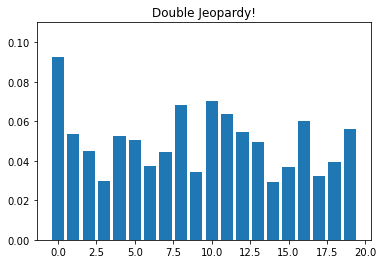

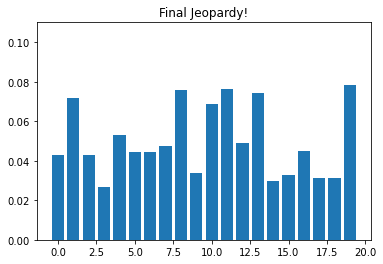

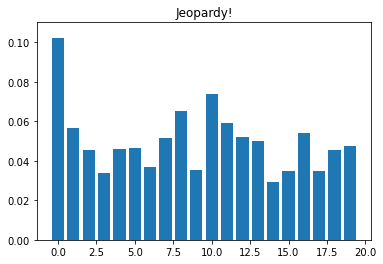

In [170]:
num_topics = len(jeopardy_df['topic'].unique())
top_topics=[]
for df in dfs[:-1]:
    topic_counts = [0]*num_topics
    for topic in df['topic']:
        topic_counts[topic]+=1
    topics_perc = [count/sum(topic_counts) for count in topic_counts]
    plt.bar(range(20), topics_perc)
    plt.title(df['round'].iloc[0])
    plt.ylim(0, 0.11)
    plt.show()
    top_topics.append((-np.array(topics_perc)).argsort()[:5])

The above plots shows the frequency of each topic for each round. When comparing the Jeopardy and Double Jeopardy rounds we can see that the distrubtions are similar, which suggusts you may most often find questions of similar topics in these rounds. 

In [248]:
top_topics # Double Jeopardy, Final Jeopardy, Jeopardy
pd.DataFrame(top_topics, index = ['Double Jeopardy', 'Final Jeopardy', 'Jeopardy'], columns = [1,2,3,4,5])

,1,2,3,4,5
Double Jeopardy,0,10,8,11,16
Final Jeopardy,19,11,8,13,1
Jeopardy,0,10,8,11,1


Above is the top 5 topics in each of the rounds. Both Double Jeopardy and Jeopardy have very similar top topics, while Final Jeopardy has different topics apear more frequently.

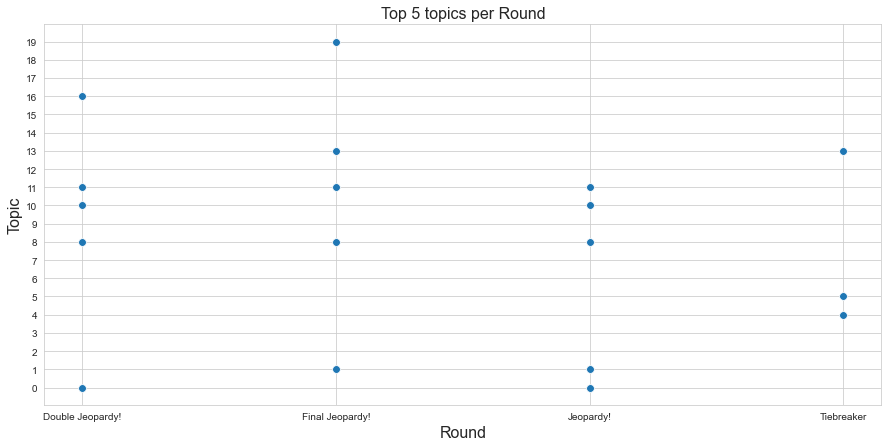

In [243]:
import seaborn as sns
a = df.groupby(['round','topic']).size().to_frame('count').reset_index()
a = a.sort_values(['round','count'], ascending=[True,False])
topk_topics = a.groupby('round').head(5).reset_index()
a = a.sort_values(['round','count'], ascending=[True,False])
topk_topics = a.groupby('round').head(5).reset_index()
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,7))

sns.scatterplot(x=topk_topics['round'], y=topk_topics['topic'], s=60)

ax.set_title('Top 5 topics per Round', size=16)
ax.set_yticks(range(20))
ax.set_xlabel('Round', size=16)
ax.set_ylabel('Topic', size=16)
plt.show()

The Jeopardy and Double Jeopardy rounds share 4 of their top 5 topics: 0, 8, 10, and 11. This means you can likely expect similar question in these two rounds most of the time. The Final Jeopardy round has different top topics than the other rounds, but still shares the top topics 8 and 11. 

Because topics 8 and 11 are so prominent it would be interesting to look at what the topics are about:

In [244]:
hard_topics = pd.DataFrame()
topic8 = lda.show_topic(8, topn = 15)
hard_topics['topic_8'] = [i[0] for i in topic8]
topic11 = lda.show_topic(11, topn = 15)
hard_topics['topic_11'] = [i[0] for i in topic11]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_8,know,word,come,may,name,letter,call,water,language,follow,mean,meaning,phrase,creature,governor
topic_11,city,name,war,home,century,river,mile,land,battle,lose,area,add,lie,capital,father


Topic 8 appears to be related to language and writing. Topic 11 appears to be related to history and war. This is not too suprising as these are topics you would expect in a trivia show. 

The top topic for the Final Jeopardy round in topic 19. This topic does not appear in the other two rounds. So, if you hope to do well in the Final Jeopardy round if it best to know this topic!! Topic 19 is related to:

In [261]:
hard_topics = pd.DataFrame()
topic19 = lda.show_topic(19, topn = 15)
hard_topics['topic_19'] = [i[0] for i in topic19]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_19,year,write,begin,book,end,number,point,change,flag,inspire,sister,director,side,center,novel


Topic 19 appears to be related to literature. So know your literature if you hope to do well in the Final Jeopardy round! 

# Analysis of Rounds over time

In [141]:
def plot_distbns(df, k=None):
    """
    plots distribtions
    AND
    return the top k topics for each year
    """
    year_idx = []
    d = {i:[0]*20 for i in range(1984,2013)}
    for i, row in df.iterrows():
        topic = d[row['year']]
        topic[row['topic']]+=1
        d[row['year']] = topic

    #calculating percent of each topic per year
    for year in d:
        d[year] = [count/sum(d[year]) for count in d[year]]
        if k is not None:
            idx = (-np.array(d[year])).argsort()[:k]
            year_idx.append(idx)
    #plotting dibstribnitons   
    fig, axs = plt.subplots(4,7,figsize=(22,12))
    index= 0
    years = list(d.keys())
    for i in range(4):
        for j in range(7):
            axs[i,j].bar(range(20), d[years[index]])
            axs[i,j].set_title(years[index])
            axs[i,j].set_ylim([0.0, 0.14])
            index +=1
    return year_idx

In [203]:
def plot_top_topics(df):
    import seaborn as sns
    a = df.groupby(['year','topic']).size().to_frame('count').reset_index()
    a = a.sort_values(['year','count'], ascending=[True,False])
    topk_topics = a.groupby('year').head(5).reset_index()
    a = a.sort_values(['year','count'], ascending=[True,False])
    topk_topics = a.groupby('year').head(5).reset_index()
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(15,7))

    sns.scatterplot(x=topk_topics['year'], y=topk_topics['topic'], s=60)
    round_name = df['round'].iloc[0]
    ax.set_title('Top 5 topics per Year in {} Round'.format(round_name), size=16)
    ax.set_xticks(range(1984, 2013))
    ax.set_yticks(range(20))
    ax.set_xlabel('Year', size=16)
    ax.set_ylabel('Topic', size=16)
    plt.show()

## Double Jeopardy

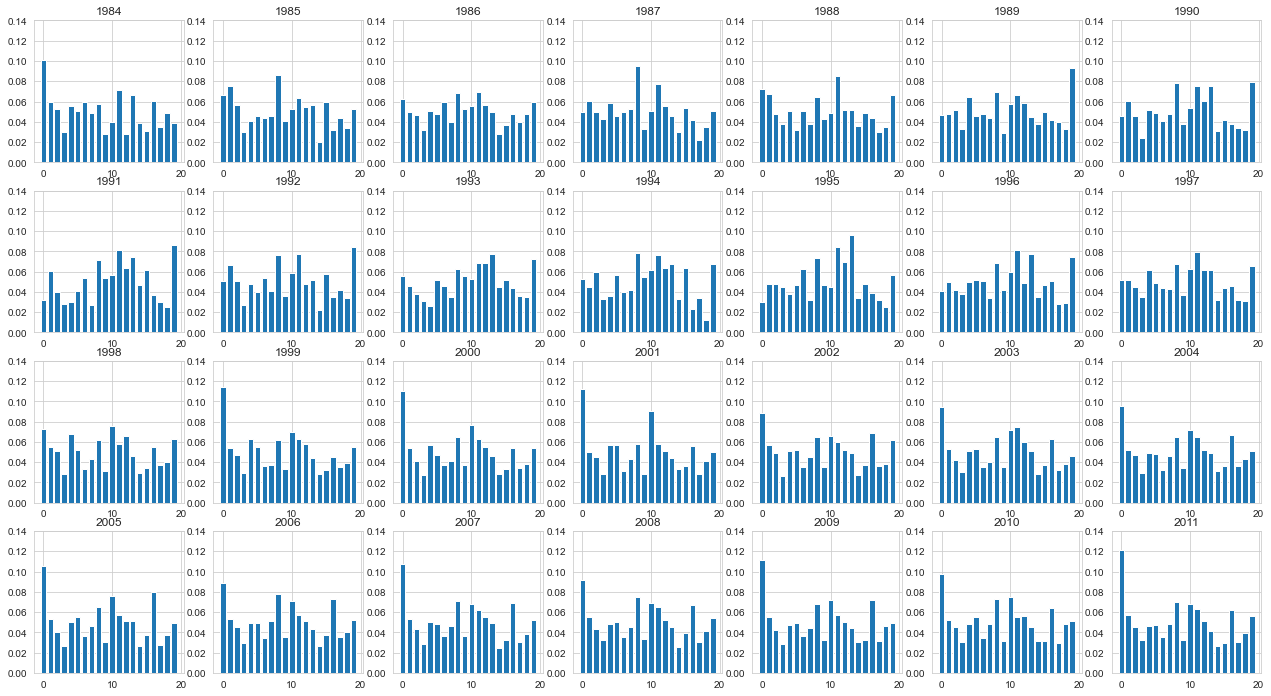

In [188]:
double_idx = plot_distbns(dfs[0],5)

In [258]:
# 5 most common topics each year
pd.DataFrame(double_idx, index = range(1984, 2013), columns = [1,2,3,4,5])

,1,2,3,4,5
1984,0,11,13,16,1
1985,8,1,0,11,15
1986,11,8,0,6,19
1987,8,11,1,4,12
1988,11,0,1,19,8
1989,19,8,11,4,12
1990,19,8,13,11,1
1991,19,11,13,8,12
1992,19,11,8,1,10
1993,13,19,12,11,8


The most common Double Jeopardy topic (0) has been consistent over the last 14 years. After a 9 year drought of that topic in the top five just two years prior

The topic words of topic 0 are as follows:

In [210]:
hard_topics = pd.DataFrame()
topic0 = lda.show_topic(0, topn = 15)
hard_topics['topic_0'] = [i[0] for i in topic0]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_0,time,one,die,age,art,read,site,design,visit,rule,poem,building,store,drink,note


From these words it appear this topic is closely related to the arts. 

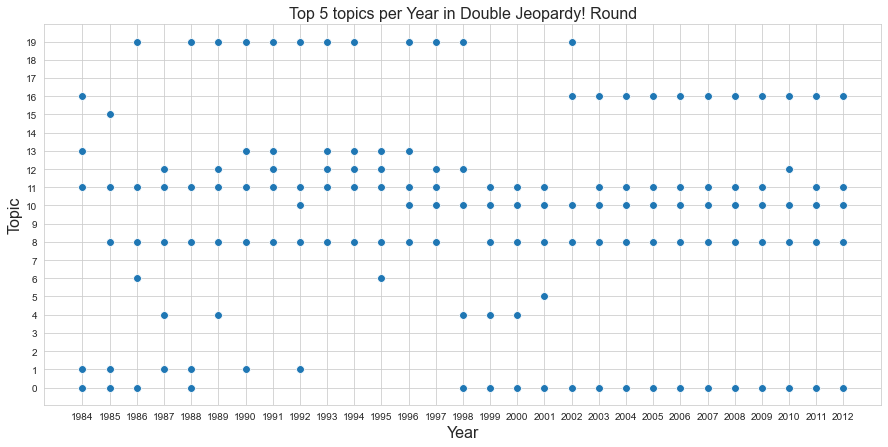

In [205]:
plot_top_topics(dfs[0])

Topic 11 has consistently been in the top 5 topics across all the years. The top words from topic 11 are as follows:

In [211]:
hard_topics = pd.DataFrame()
topic11 = lda.show_topic(11, topn = 15)
hard_topics['topic_11'] = [i[0] for i in topic11]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_11,city,name,war,home,century,river,mile,land,battle,lose,area,add,lie,capital,father


Based on these words we can say that topic 11 is related to history, particularly with war. 

# Final Jeopardy

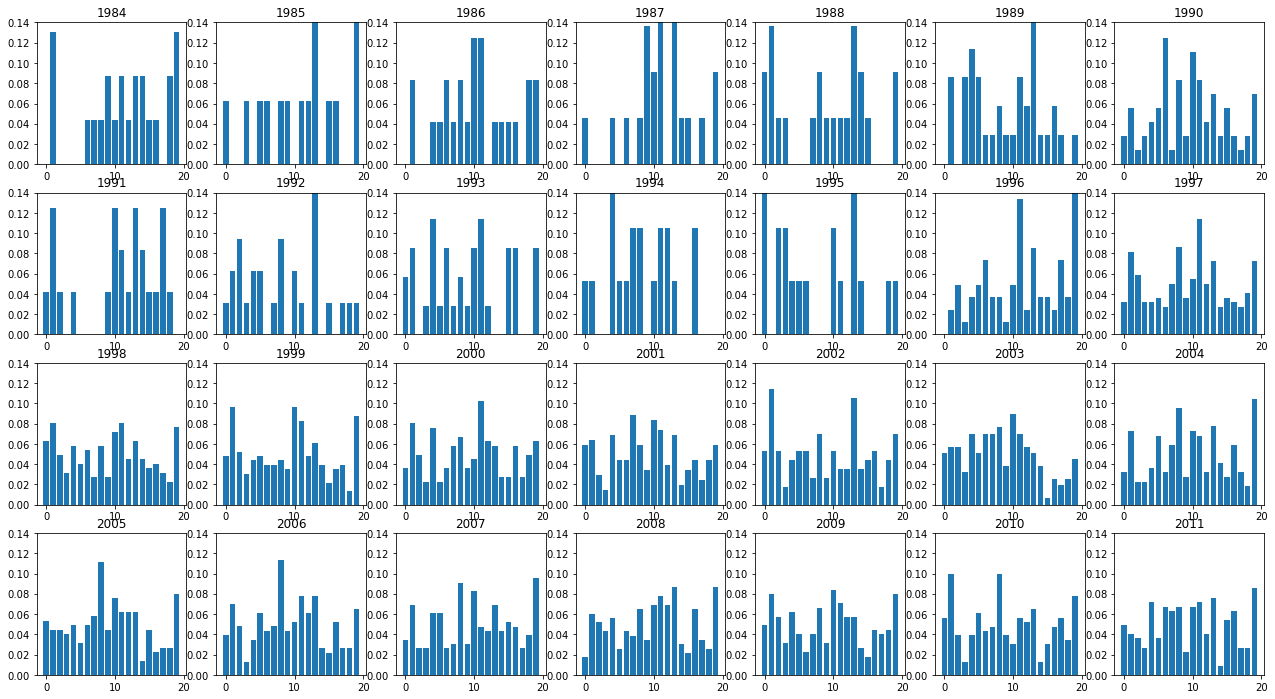

In [162]:
final_idx = plot_distbns(dfs[1], 5)

The first 10 years there was less diversity of topics. The variety of questions were limited to less than 20 topics. The more recent 10 became much more diverse across all topics

In [259]:
# 5 most common topics each year
pd.DataFrame(final_idx, index = range(1984, 2013), columns = [1,2,3,4,5])

,1,2,3,4,5
1984,19,1,14,13,11
1985,19,13,16,15,12
1986,11,10,19,1,6
1987,13,11,9,10,19
1988,1,13,0,14,8
1989,13,4,1,3,5
1990,6,10,8,11,19
1991,1,17,13,10,14
1992,13,2,8,1,4
1993,4,11,19,1,16


The Final Jeopardy round has much more variety of topics each year.

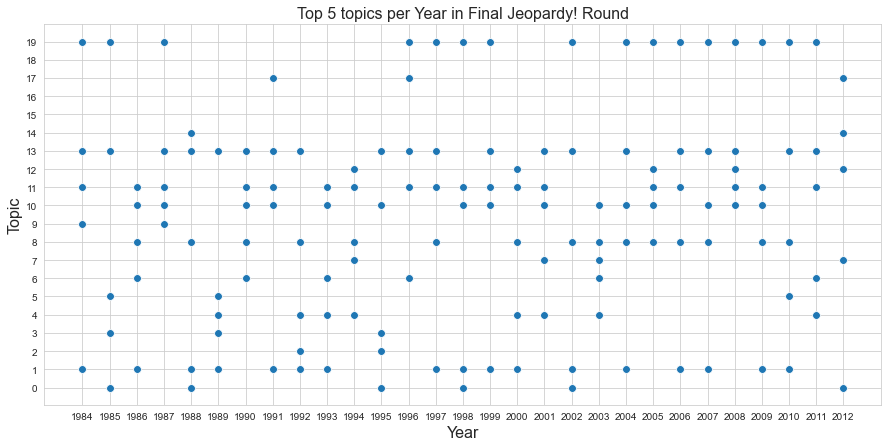

In [195]:
plot_top_topics(dfs[1])

Topics 15, 16, and 17 never appear in the top 5 topics

Topic 14 only occured twice, in years 2012 and 1988! It would be interesting to see what this topic is.

In [212]:
hard_topics = pd.DataFrame()
topic14 = lda.show_topic(14, topn = 15)
hard_topics['topic_14'] = [i[0] for i in topic14]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_14,island,line,movie,child,introduce,study,award,ride,office,earth,player,fight,name,heart,hero


This topic appears to be related to movies. 

# Jeopardy

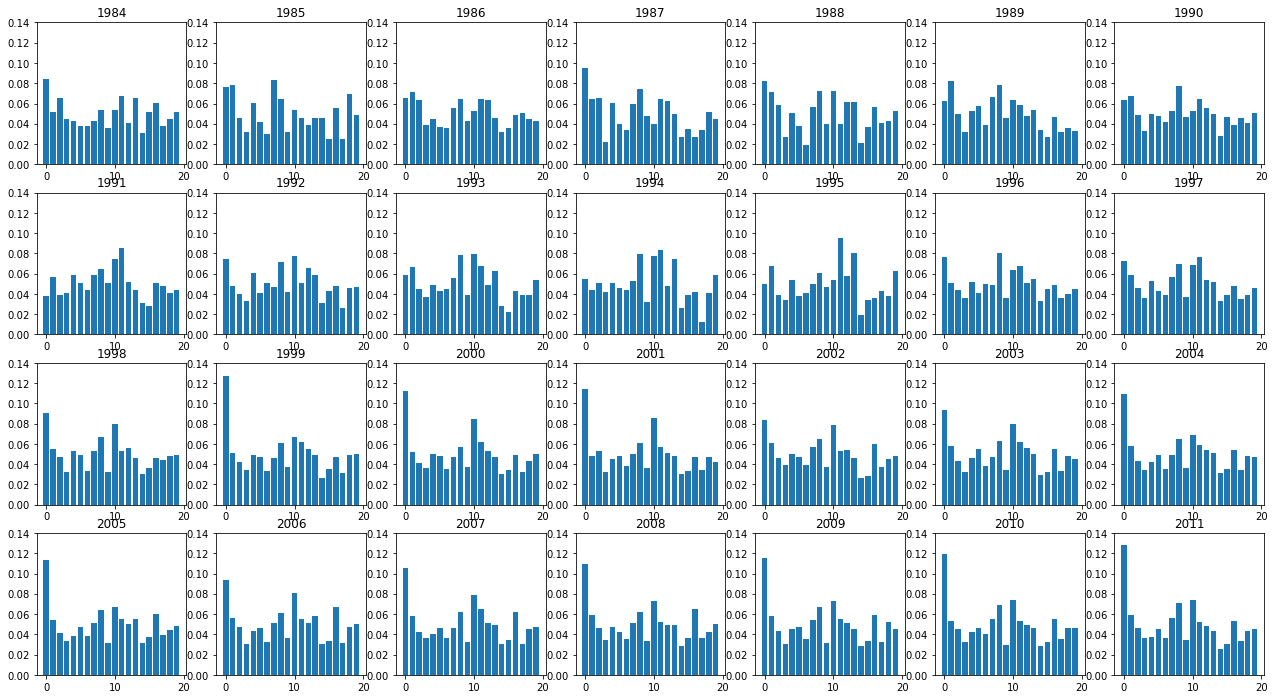

In [165]:
j_idx = plot_distbns(dfs[2], 5)

In [260]:
# 5 most common topics each year
pd.DataFrame(j_idx, index = range(1984, 2013), columns = [1,2,3,4,5])

,1,2,3,4,5
1984,0,11,2,13,16
1985,7,1,0,18,8
1986,1,0,8,11,2
1987,0,8,2,1,11
1988,0,10,8,1,13
1989,1,8,7,10,0
1990,8,1,11,0,12
1991,11,10,8,4,7
1992,10,0,8,12,4
1993,10,8,11,1,13


Question topics have been consistent in recent years. 14 of the last 15 years all have topics 0 and topic 10 as the two most common. 

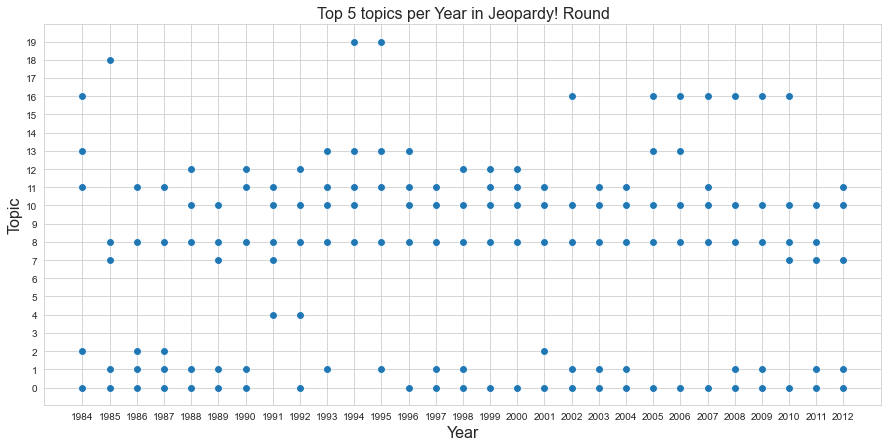

In [196]:
plot_top_topics(dfs[2])

Topics 0, 1, 8, 10, and 11 are consitently in the top 5 topics each year. While topics such as 3, 5, 14, and 17 never appear in the top 5.

It would be interesting to see what topic 8 is, as it is so popular

In [213]:
hard_topics = pd.DataFrame()
topic8 = lda.show_topic(8, topn = 15)
hard_topics['topic_8'] = [i[0] for i in topic8]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_8,know,word,come,may,name,letter,call,water,language,follow,mean,meaning,phrase,creature,governor


Topic 8 appear to be related to language and writing. 

Topic 18 only appeared once in nearly 30 years! Wonder what that topic could be...

In [214]:
hard_topics = pd.DataFrame()
topic18 = lda.show_topic(18, topn = 15)
hard_topics['topic_18'] = [i[0] for i in topic18]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_18,go,be,put,actor,nation,ship,sing,say,fire,top,let,field,make,send,church


Hard to come up with a topic from these but seems to be related to the Navy, with words like 'nation', 'ship', 'sing', 'send', 'fire', etc...

In [131]:
df.groupby(['round','topic']).size().to_frame('count').reset_index()

,round,topic,count
0,Double Jeopardy!,0,9803
1,Double Jeopardy!,1,5692
2,Double Jeopardy!,2,4747
3,Double Jeopardy!,3,3176
4,Double Jeopardy!,4,5550
...,...,...,...
58,Jeopardy!,18,4879
59,Jeopardy!,19,5081
60,Tiebreaker,4,1
61,Tiebreaker,5,1


# Summary of findings

When comparing the topics between the three rounds of Jeopardy (Jeopardy, Double Jeopardy, and Final Jeopardy) we found that the most common topics used in the Jeopardy and Double Jeopardy rounds are almost the same. In their top 5 topics they shared four which were 0, 8, 10, 11. This means you can most likely expect similar topics in these two rounds.  The Final Jeopardy round's most common topics were different, but did still included topics 8 and 11. Topic 8 seemed to be related to writing and language, while topics 11 seemed to be related to history and war. So the take away from this is knowing topics 8 and 11 can be very useful if you want to do well across all the rounds. On the other hand, if you want to do well particularly in the Final Jeopardy round is would be very helpful to know topic 19, which is related to literature. 

When looking at the Jeopardy round over time we saw that of the 15 most recent years, 14 of them had the same top 2 topic (0 and 10). This means the topics of questions you most often would see in this round have not changed in over a decade. Topics 0, 1, 8, 10, and 11 are consitently in the top 5 topics each year. While topics such as 3, 5, 14, and 17 never appear in the top 5.

We see something similar in the Double Jeopard round. Each of the past 14 years' top topics were the same, topic 0. This comes just two years after a 9 year streak of topic 0 not being in top 5 most common topic at all. Topic 0 seems to be related to the arts. 

In the Final Jeopardy round, during the 1980s and 1990s most of the questions were limited to a few topics. There were several topics in which no question was asked in those earlier years. In more recent years, the diversity of the topics increased, and the top 5 topics consistently change each year. Topics 15, 16, and 17 never appear in the top 5 topics. Topic 18 appeared once in nearly 30 years!